In [8]:
# Transfer learning
import os
import json
from PIL import Image

import torch
import torch.utils.data as data
from torchvision import models
import torchvision.transforms.v2 as tfs_v2
import torch.nn as no
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn

# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class DogDataset(data.Dataset):
    def __init__(self, path, train=True, transform=None):
        self.path = os.path.join(path, "train" if train else "test")
        self.transform = transform

        with open(os.path.join(self.path, "format.json"), "r") as fp:
            self.format = json.load(fp)
        
        self.length = 0
        self.files = []
        self.targets = torch.eye(10) # one hot

        for _dir, _target in self.format.items():
            path = os.path.join(self.path, _dir)
            list_files = os.listdir(path)
            self.length += len(list_files)
            self.files.extend( map(lambda _x: (os.path.join(path , _x), _target ), list_files ))

    def __getitem__(self, index):
        path_file, target = self.files[index]
        t = self.targets[target]
        img = Image.open(path_file)

        if self.transform:
            img = self.transform(img)
        return img, t
    
    def __len__(self):
        return self.length


# Loading resnet weigths
resnet_wgts = models.ResNet50_Weights.DEFAULT
transforms = resnet_wgts.transforms()

# Model
model = models.resnet50(weights = resnet_wgts)
model.requires_grad_(False) # disable grads

# modify Layers
model.fc = nn.Linear(512*4, 10)
model.fc.requires_grad_(True) # Enable gradient for last layer

# crating datasets
d_train = DogDataset('datasets\\dogs', transform=transforms)
train_data = data.DataLoader(d_train, batch_size=32, shuffle=True)

# Optimzer
optimizer  = optim.Adam(params=model.fc.parameters() , lr=0.001, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()
epochs = 3
model.train()

# Train
model.to(device)
for _e in range(epochs):
    loss_mean  = 0
    lm_cont = 0

    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        predict = model(x_train)
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_cont +=1
        loss_mean  = 1 / lm_cont * loss.item() - (1 - 1/lm_cont) * loss_mean
        train_tqdm.set_description(f"Epoch {_e+1}/{epochs}, loss_mean: {loss_mean:.4f}")

# Saving
st = model.state_dict()
torch.save(st, 'resnet_50_trnsfer.tar')

# Test
Q = 0
P = 0
count = 0
model.eval()

d_test = DogDataset('datasets\\dogs',train=False, transform=transforms)
test_data = data.DataLoader(d_test , batch_size=50 , shuffle=False)
test_tqdm = tqdm(test_data, leave=True)
for x_test, y_test in test_tqdm:
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    with torch.no_grad():
        p = model(x_test)
        p2 = torch.argmax(p , dim=1)
        y = torch.argmax(y_test, dim=1)
        P += torch.sum(p2 == y).item()
        Q +=loss_function(p, y_test).item()
        count +=1

Q /= count
P /=len(d_test)
print(Q)
print(P)

Using device: cuda


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]

0.31996253452130724
0.9463722397476341


Using device: cuda


Epoch 1/20, loss_mean: 1.3843: 100%|██████████| 51/51 [00:06<00:00,  7.62it/s]


Epoch 1 average loss: 1.3843


Epoch 2/20, loss_mean: 0.5360: 100%|██████████| 51/51 [00:06<00:00,  7.97it/s]


Epoch 2 average loss: 0.5360


Epoch 3/20, loss_mean: 0.3540: 100%|██████████| 51/51 [00:06<00:00,  8.08it/s]


Epoch 3 average loss: 0.3540


Epoch 4/20, loss_mean: 0.2655: 100%|██████████| 51/51 [00:06<00:00,  7.89it/s]


Epoch 4 average loss: 0.2655


Epoch 5/20, loss_mean: 0.2142: 100%|██████████| 51/51 [00:07<00:00,  7.24it/s]


Epoch 5 average loss: 0.2142


Epoch 6/20, loss_mean: 0.1868: 100%|██████████| 51/51 [00:07<00:00,  7.27it/s]


Epoch 6 average loss: 0.1868


Epoch 7/20, loss_mean: 0.1576: 100%|██████████| 51/51 [00:07<00:00,  7.11it/s]


Epoch 7 average loss: 0.1576


Epoch 8/20, loss_mean: 0.1579: 100%|██████████| 51/51 [00:07<00:00,  7.14it/s]


Epoch 8 average loss: 0.1579


Epoch 9/20, loss_mean: 0.1370: 100%|██████████| 51/51 [00:07<00:00,  7.27it/s]


Epoch 9 average loss: 0.1370


Epoch 10/20, loss_mean: 0.1263: 100%|██████████| 51/51 [00:06<00:00,  7.47it/s]


Epoch 10 average loss: 0.1263


Epoch 11/20, loss_mean: 0.1188: 100%|██████████| 51/51 [00:06<00:00,  7.53it/s]


Epoch 11 average loss: 0.1188


Epoch 12/20, loss_mean: 0.1034: 100%|██████████| 51/51 [00:06<00:00,  7.48it/s]


Epoch 12 average loss: 0.1034


Epoch 13/20, loss_mean: 0.0979: 100%|██████████| 51/51 [00:06<00:00,  7.43it/s]


Epoch 13 average loss: 0.0979


Epoch 14/20, loss_mean: 0.0888: 100%|██████████| 51/51 [00:06<00:00,  7.50it/s]


Epoch 14 average loss: 0.0888


Epoch 15/20, loss_mean: 0.0958: 100%|██████████| 51/51 [00:06<00:00,  7.47it/s]


Epoch 15 average loss: 0.0958


Epoch 16/20, loss_mean: 0.0806: 100%|██████████| 51/51 [00:06<00:00,  7.45it/s]


Epoch 16 average loss: 0.0806


Epoch 17/20, loss_mean: 0.0767: 100%|██████████| 51/51 [00:06<00:00,  7.33it/s]


Epoch 17 average loss: 0.0767


Epoch 18/20, loss_mean: 0.0653: 100%|██████████| 51/51 [00:06<00:00,  7.82it/s]


Epoch 18 average loss: 0.0653


Epoch 19/20, loss_mean: 0.0780: 100%|██████████| 51/51 [00:06<00:00,  7.57it/s]


Epoch 19 average loss: 0.0780


Epoch 20/20, loss_mean: 0.0683: 100%|██████████| 51/51 [00:07<00:00,  7.26it/s]


Epoch 20 average loss: 0.0683


100%|██████████| 7/7 [00:01<00:00,  4.84it/s]



Test Results:
Average Test Loss: 0.1730
Test Accuracy: 0.9590 (95.90%)

Graphs saved as 'training_results.png'


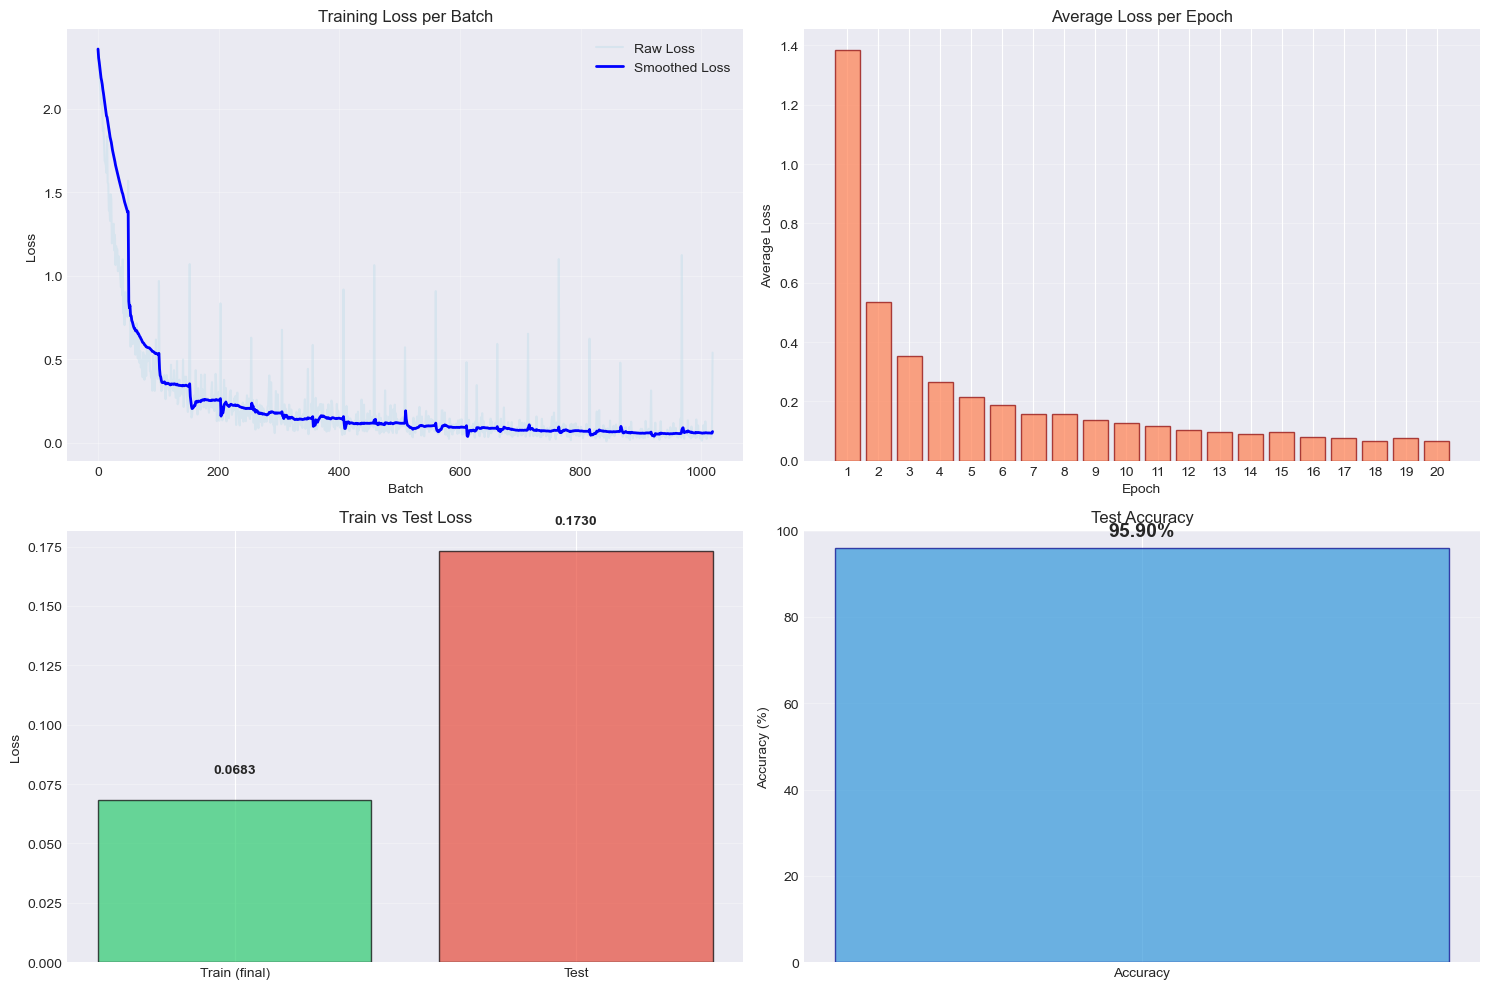

In [9]:
# Transfer learning with visualization
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import json
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
from torchvision import models
import torchvision.transforms.v2 as tfs_v2
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class DogDataset(data.Dataset):
    def __init__(self, path, train=True, transform=None):
        self.path = os.path.join(path, "train" if train else "test")
        self.transform = transform

        with open(os.path.join(self.path, "format.json"), "r") as fp:
            self.format = json.load(fp)
        
        self.length = 0
        self.files = []
        self.targets = torch.eye(10)  # one hot

        for _dir, _target in self.format.items():
            path = os.path.join(self.path, _dir)
            list_files = os.listdir(path)
            self.length += len(list_files)
            self.files.extend(map(lambda _x: (os.path.join(path, _x), _target), list_files))

    def __getitem__(self, index):
        path_file, target = self.files[index]
        t = self.targets[target]
        img = Image.open(path_file)

        if self.transform:
            img = self.transform(img)
        return img, t
    
    def __len__(self):
        return self.length


# Loading resnet weights
resnet_wgts = models.ResNet50_Weights.DEFAULT
transforms = resnet_wgts.transforms()

# Model
model = models.resnet50(weights=resnet_wgts)
model.requires_grad_(False)  # disable grads

# Modify Layers
model.fc = nn.Linear(512*4, 10)
model.fc.requires_grad_(True)  # Enable gradient for last layer

# Creating datasets
d_train = DogDataset('datasets\\dogs', transform=transforms)
train_data = data.DataLoader(d_train, batch_size=32, shuffle=True)

# Optimizer
optimizer = optim.Adam(params=model.fc.parameters(), lr=0.001, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()
epochs = 20
model.train()

# Lists for tracking metrics
train_losses = []
train_losses_smoothed = []
epoch_losses = []

# Train
model.to(device)
for _e in range(epochs):
    loss_mean = 0
    lm_cont = 0
    epoch_loss_sum = 0
    epoch_batches = 0

    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        predict = model(x_train)
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Исправленная формула скользящего среднего (экспоненциальное сглаживание)
        lm_cont += 1
        alpha = 1 / lm_cont  # коэффициент сглаживания
        loss_mean = alpha * loss.item() + (1 - alpha) * loss_mean
        
        # Сохранение метрик
        train_losses.append(loss.item())
        train_losses_smoothed.append(loss_mean)
        epoch_loss_sum += loss.item()
        epoch_batches += 1
        
        train_tqdm.set_description(f"Epoch {_e+1}/{epochs}, loss_mean: {loss_mean:.4f}")
    
    # Средний loss за эпоху
    epoch_avg_loss = epoch_loss_sum / epoch_batches
    epoch_losses.append(epoch_avg_loss)
    print(f"Epoch {_e+1} average loss: {epoch_avg_loss:.4f}")

# Saving
st = model.state_dict()
torch.save(st, 'resnet_50_transfer.tar')

# Test
test_loss = 0
correct = 0
total_batches = 0
model.eval()

d_test = DogDataset('datasets\\dogs', train=False, transform=transforms)
test_data = data.DataLoader(d_test, batch_size=50, shuffle=False)
test_tqdm = tqdm(test_data, leave=True)

for x_test, y_test in test_tqdm:
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    with torch.no_grad():
        p = model(x_test)
        p2 = torch.argmax(p, dim=1)
        y = torch.argmax(y_test, dim=1)
        correct += torch.sum(p2 == y).item()
        test_loss += loss_function(p, y_test).item()
        total_batches += 1

test_loss /= total_batches
accuracy = correct / len(d_test)

print(f"\nTest Results:")
print(f"Average Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Визуализация результатов
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Loss по батчам (raw и сглаженный)
ax1 = axes[0, 0]
ax1.plot(train_losses, alpha=0.3, label='Raw Loss', color='lightblue')
ax1.plot(train_losses_smoothed, label='Smoothed Loss', color='blue', linewidth=2)
ax1.set_xlabel('Batch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss per Batch')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Средний loss по эпохам
ax2 = axes[0, 1]
ax2.bar(range(1, epochs+1), epoch_losses, color='coral', alpha=0.7, edgecolor='darkred')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Loss')
ax2.set_title('Average Loss per Epoch')
ax2.set_xticks(range(1, epochs+1))
ax2.grid(True, alpha=0.3, axis='y')

# 3. Сравнение Train vs Test Loss
ax3 = axes[1, 0]
final_train_loss = epoch_losses[-1]
losses_comparison = [final_train_loss, test_loss]
colors = ['#2ecc71', '#e74c3c']
ax3.bar(['Train (final)', 'Test'], losses_comparison, color=colors, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Loss')
ax3.set_title('Train vs Test Loss')
ax3.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(losses_comparison):
    ax3.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# 4. Test Accuracy
ax4 = axes[1, 1]
ax4.bar(['Accuracy'], [accuracy*100], color='#3498db', alpha=0.7, edgecolor='darkblue', width=0.5)
ax4.set_ylabel('Accuracy (%)')
ax4.set_title('Test Accuracy')
ax4.set_ylim(0, 100)
ax4.grid(True, alpha=0.3, axis='y')
ax4.text(0, accuracy*100 + 2, f'{accuracy*100:.2f}%', ha='center', va='bottom', 
         fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
print("\nGraphs saved as 'training_results.png'")
plt.show()

In [2]:
# 3
import torch
from torchvision import models
import torchvision.transforms.functional as TF

# тензор x и img_pil в программе не менять
x = torch.randint(0, 255, (3, 100, 100), dtype=torch.float32) 
img_pil = TF.to_pil_image(x)

# здесь продолжайте программу
model = models.resnet34()
model.requires_grad_(False)

wgts = models.ResNet34_Weights.DEFAULT
transforms = wgts.transforms()

img_t = transforms(img_pil)

model.eval()
results = model(img_t.unsqueeze(0))

In [ ]:
# 4
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms.functional as TF

# тензор x и img_pil в программе не менять
x = torch.randint(0, 255, (3, 250, 250), dtype=torch.float32)
img_pil = TF.to_pil_image(x)

# здесь продолжайте программу
model = models.resnet50()
model.requires_grad_(False)
model.fc = nn.Sequential(
    nn.Linear(512*4, 128, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(128,10, bias=True)
)
model.fc.requires_grad_(False)

model.eval()
wgts = models.ResNet50_Weights.DEFAULT
transforms = wgts.transforms()
img_t = transforms(img_pil)

predict = model(img_t.unsqueeze(0))

In [10]:
# 5 
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms.functional as TF

# тензор x и img_pil в программе не менять
x = torch.randint(0, 255, (3, 250, 250), dtype=torch.float32)
img_pil = TF.to_pil_image(x)

# здесь продолжайте программу
model = models.resnet50()
model.fc = nn.Sequential(
    nn.Linear(512*4, 100, bias=False),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    nn.Linear(100,10, bias=True)
)

model.eval()
wgts = models.ResNet50_Weights.DEFAULT
transforms = wgts.transforms()
img_t = transforms(img_pil)

with torch.no_grad():
    predict = model(img_t.unsqueeze(0))

In [12]:
# 6 
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim

class FuncModel(nn.Module):
    def __init__(self):
        super().__init__()
        # модель однослойной полносвязной нейронной сети:
        # 1-й слой: число входов 5 (x, x^2, x^3, x^4, x^5), число нейронов 1
        self.layer = nn.Linear(5, 1 )

    def forward(self, x):
        x.unsqueeze_(-1)
        xx = torch.cat([x, x ** 2, x ** 3, x ** 4, x ** 5], dim=1)
        y = self.layer(xx)
        return y


torch.manual_seed(1)

model = FuncModel()# создать модель FuncModel

epochs = 20 # число эпох обучения
batch_size = 16 # размер батча

# данные обучающей выборки (значения функции)
data_x = torch.arange(-5, 5, 0.05) #тензоры data_x, data_y не менять
data_y = torch.sin(2 * data_x) - 0.3 * torch.cos(8 * data_x) + 0.1 * data_x ** 2

ds = data.TensorDataset(data_x, data_y) # создание dataset
d_train, d_val = data.random_split(ds, [0.7, 0.3])  # разделить ds на две части в пропорции: 70% на 30%
train_data = data.DataLoader(d_train,batch_size=batch_size,shuffle=True) # создать объект класса DataLoader для d_train с размером пакетов batch_size и перемешиванием образов выборки
train_data_val = data.DataLoader(d_val,batch_size=batch_size,shuffle=False) # создать объект класса DataLoader для d_val с размером пакетов batch_size и без перемешивания образов выборки

optimizer = optim.RMSprop(params=model.parameters(), lr=0.01) # создать оптимизатор RMSprop для обучения модели с шагом обучения 0.01
loss_func = nn.MSELoss()# создать функцию потерь с помощью класса MSELoss

loss_lst_val = []  # список значений потерь при валидации
loss_lst = []  # список значений потерь при обучении

for _e in range(epochs):
    # перевести модель в режим обучения
    model.train()
    loss_mean = 0 # вспомогательные переменные для вычисления среднего значения потерь при обучении
    lm_count = 0

    for x_train, y_train in train_data:
        predict = model(x_train) # вычислить прогноз модели для данных x_train
        loss = loss_func(predict, y_train) # вычислить значение функции потерь

        # сделать один шаг градиентного спуска для корректировки параметров модели
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # вычисление среднего значения функции потерь по всей выборке
        lm_count += 1
        loss_mean = 1 / lm_count * loss.item() + (1 - 1 / lm_count) * loss_mean

    # валидация модели
    # перевести модель в режим эксплуатации
    model.eval()
    Q_val = 0
    count_val = 0

    for x_val, y_val in train_data_val:
        with torch.no_grad():
            p = model(x_val)
            loss = loss_func(p, y_val.unsqueeze(-1))
            Q_val += loss.item()
            count_val +=1
            # для x_val, y_val вычислить потери с помощью функции loss_func

    # сохранить средние потери, вычисленные по выборке валидации, в переменной Q_val
    Q_val /= count_val

    loss_lst.append(loss_mean)
    loss_lst_val.append(Q_val)

# перевести модель в режим эксплуатации
model.eval()
# выполнить прогноз модели по всем данным выборки (ds.data)
p = model(data_x)
Q = loss_func(p, data_y.unsqueeze(-1)).item()
# вычислить потери с помощью loss_func по всем данным выборки ds; значение Q сохранить в виде вещественного числа

c:\Users\pantu\.conda\envs\dl\Lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\pantu\.conda\envs\dl\Lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
